# **[TUTORIAL] QAOA to solve MaxCut**

- Chạy code với hướng dẫn theo bài viết của IBM
  
    - Source: [tutorial-quantum-approximate-optimization-algorithm](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)

## [SimulatorAer] Test 7 Node, 9 Edge

### **Build GRAPH**

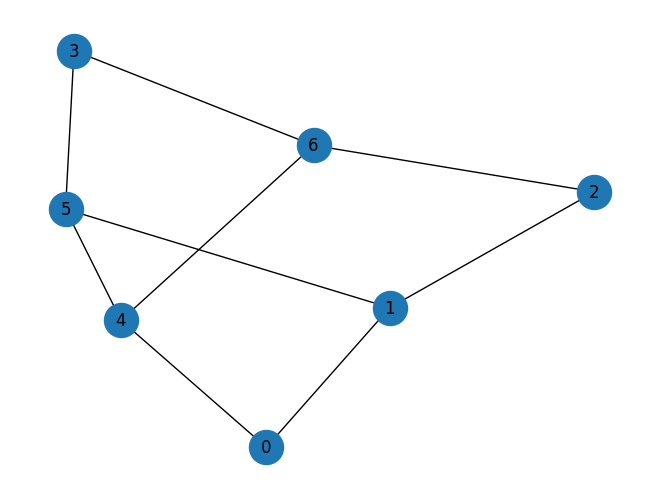

In [2]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

node_number = 7

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, node_number, 1))
edge_list = [(0, 1, 1), (0, 4, 1), (1, 5, 1), (1, 2, 1), (2, 6, 1), (3, 5, 1), (3, 6, 1), (4, 6, 1), (4, 5, 1)]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)  

### **Build Hamiltonian dưới dạng toán tử Pauli Z**

In [3]:
from qiskit.quantum_info import SparsePauliOp

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("".join(paulis)[::-1], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIZZ', 'IIZIIIZ', 'IZIIIZI', 'IIIIZZI', 'ZIIIZII', 'IZIZIII', 'ZIIZIII', 'ZIZIIII', 'IZZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


Sau bước này, Hamiltonian sẽ trông như thế này:
  
$H_C = IIIIIZZ + IIZIIIZ + IZIIIZI + IIIIZZI + ZIIIZII + IZIZIII + ZIIZIII + ZIZIIII + IZZIIII$

### **Tạo mạch QAOA bằng QAOAAnsatz**

In [4]:
from qiskit.circuit.library import QAOAAnsatz

# Build QAOAAnsatz với Hamiltonian đã build trước đó, có 4 lớp
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=4)
circuit.measure_all()

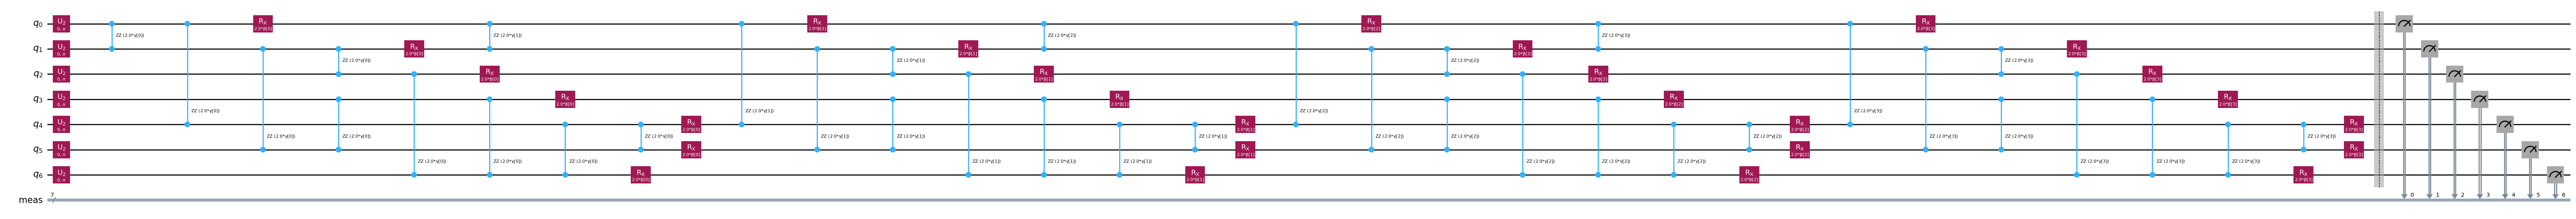

In [5]:
circuit.decompose().decompose().draw('mpl', fold=False, idle_wires=False)

In [6]:
from qiskit_aer.primitives import SamplerV2, EstimatorV2
from qiskit import transpile
from scipy.optimize import OptimizeResult
import numpy as np
from qiskit_aer import AerSimulator

# Khởi tạo backend
backen = AerSimulator()
# Biên dịch mạch phù hợp với backend của Aer
circ_ISA_Aer = transpile(circuit, backen)

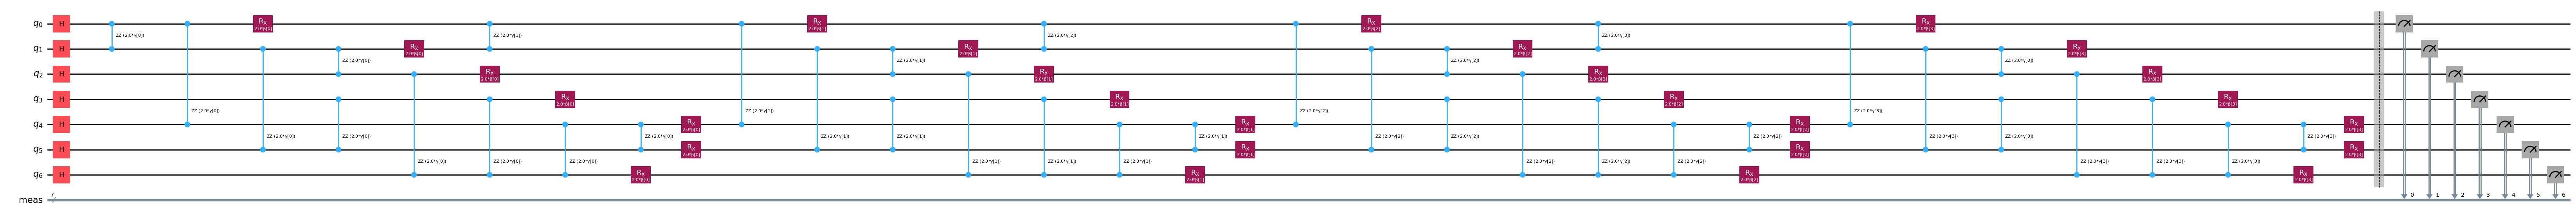

In [7]:
circ_ISA_Aer.draw('mpl', fold=False, idle_wires=False)

### Khởi tạo tham số ban đầu

In [8]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta, initial_gamma, initial_beta, initial_gamma, initial_beta]

### **Thuật toán cổ điển COBYLA lặp lại việc chạy Estimator để tìm giá trị kỳ vọng đủ tốt**

In [ ]:
from scipy.optimize import minimize

# Lưu lại các giá trị sau mỗi lần tính
objective_func_vals = [] 

# HÀM NÀY ĐỂ TÍNH GIÁ TRỊ KỲ VỌNG CỦA MẠCH LƯỢNG TỬ ANSATZ DƯỚI TÁC ĐỘNG CỦA TOÁN TỬ HAMILTONIAN VỚI BỘ THAM SỐ
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    '''
    CÁC THAM SỐ CỦA HÀM BAO GỒM:
        - Bộ tham số (cái thay đổi và cần được tối ưu)
        - ansatz: Là mạch lượng tử của chúng ta (Sau khi được build ra mạch ISA)
        - hamiltonian: Là toán tử đã build ra được dưới dạng toán tử Pauli Z như ở trên (Trước khi build ra mạch ISA)
        - estimatorL Công cụ để chạy tính toán

    CÁCH HOẠT ĐỘNG CỦA HÀM NÀY:
        1. Build mạch ISA hamiltonian để chạy trên mạch lượng tử ISA đã build trước đó
        2. Chạy Estimator với thông tin bao gồm: 
            Mạch cần chạy (ansatz), 
            toán tử Hamiltonian sau khi build mạch ISA, 
            bộ tham số
        3. Lấy kết quả từ Estimator, lưu vào List, trả về giá trị kỳ vọng sau khi tính
    '''

    # Build mạch ISA cho Hamiltonian
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    # Tạo Pub với thông tin bào gồm
    pub = (ansatz, isa_hamiltonian, params)
    # Chạy với estimator
    job = estimator.run([pub])

    # Lấy giá trị kỳ vọng sau khi tính
    results = job.result()[0]
    cost = results.data.evs

    # Lưu kết quả lại
    objective_func_vals.append(cost)
    return cost



# Khởi tạo và định nghĩa một số thông số cho Estimator
estimator = EstimatorV2()
estimator.options.default_shots = 16

# # Set simple error suppression/mitigation options
# estimator.options.dynamical_decoupling.enable = True
# estimator.options.dynamical_decoupling.sequence_type = "XY4"
# estimator.options.twirling.enable_gates = True
# estimator.options.twirling.num_randomizations = "auto"


'''
CÁCH HOẠT ĐỘNG CỦA HÀM minimize()
    1. Minimize() lấy giá trị của tham số ban đầu: init_params
    2. Minimize() gọi hàm cost_func_estimator() để tính giá trị kỳ vọng
    3. Minimize() thay đổi tham số để giảm giá trị kỳ vọng
    4. Minimize() lặp lại việc gọi hàm cost_func_estimator() để tính giá trị kỳ vọng
    5. Minimize() sẽ dừng lại khi đạt đến ngưỡng $tol=1e-2$ hoặc số vòng lặp tối đa
    6. Minimize() trả về result.
'''
result = minimize(
    cost_func_estimator,
    init_params, 
    args=(circ_ISA_Aer, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

print("Optimized parameters (gamma and beta):", result.x)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.431640625
       x: [ 3.624e+00  3.075e+00  3.139e+00  1.289e+00  2.788e+00
            1.303e+00  2.622e+00  1.169e+00]
    nfev: 73
   maxcv: 0.0


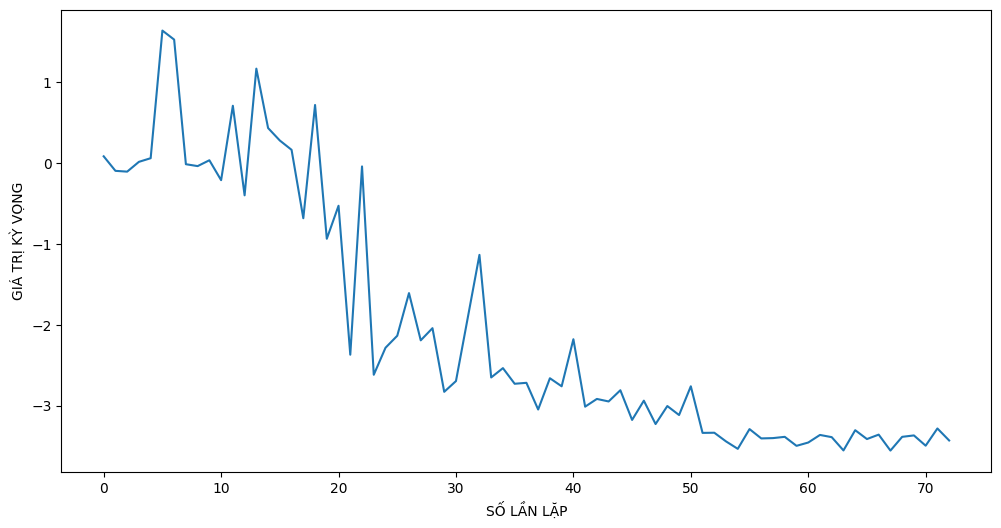

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("SỐ LẦN LẶP")
plt.ylabel("GIÁ TRỊ KỲ VỌNG")
plt.show()

### **Build mạch với các tham số đã được tối ưu**

Sau khi có các giá trị Gamma, Beta đã được tối ưu từ thuật toán cổ điển. Bây giờ, chúng ta build mạch với tham số đã có

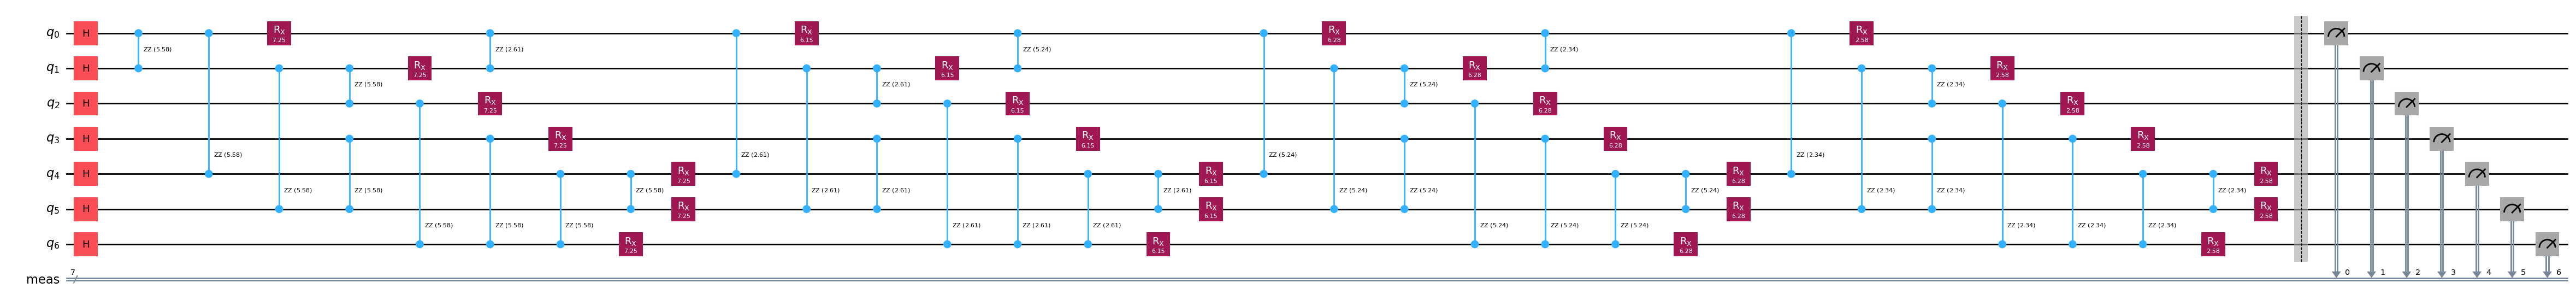

In [12]:
# Xây dựng mạch mới với các giá trị Gamma, Beta đã tối ưu
optimized_circuit = circ_ISA_Aer.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

### **Chạy Sampler để lấy phân phối xác suất**

In [13]:
sampler = SamplerV2()
sampler.options.default_shots = 1024

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
# hoặc ->   job = sampler.run([(circuit1,), (circuit2,)], shots=10000)

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())

final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

print(final_distribution_bin)


# Lấy 4 key có value lớn nhất
sorted_distribution = sorted(final_distribution_bin.items(), key=lambda item: item[1], reverse=True)
top_4_keys = []
print("4 giá trị lớn nhất:")
for i in range(min(4, len(sorted_distribution))): 
    key, val = sorted_distribution[i]
    top_4_keys.append(key)
    print(f"Key: {key}, Value: {val}")



# Tạo ra List để vẽ đồ thị và tính số vết cắt
reversed_lists = [] # Lưu danh sách kết quả
for key in top_4_keys:
    reversed_key = key[::-1]  # Đảo ngược chuỗi
    split_list = [int(char) for char in reversed_key]  # Tách từng ký tự và chuyển thành số nguyên
    reversed_lists.append(split_list)  # Thêm vào danh sách kết quả

list1 = [int(char) for char in top_4_keys[0][::-1]]
list2 = [int(char) for char in top_4_keys[1][::-1]]
list3 = [int(char) for char in top_4_keys[2][::-1]]
list4 = [int(char) for char in top_4_keys[3][::-1]]

{'1000101': 0.0096, '1110010': 0.0756, '0001011': 0.0085, '0011110': 0.0489, '1001001': 0.0086, '1000110': 0.0023, '1100101': 0.0495, '0100101': 0.0443, '0111101': 0.0222, '0010011': 0.001, '0011100': 0.0471, '0001101': 0.0703, '0111100': 0.0125, '0001010': 0.0131, '1000010': 0.0258, '1100001': 0.0478, '0110010': 0.001, '0100100': 0.0092, '1011010': 0.045, '0111110': 0.0131, '0110101': 0.0124, '1000011': 0.0125, '0000111': 0.001, '1110100': 0.0093, '1100010': 0.0151, '1100011': 0.0435, '0011010': 0.0504, '0001100': 0.0058, '0010010': 0.0069, '1110101': 0.0114, '1100000': 0.008, '0111111': 0.0031, '0001001': 0.0121, '0010100': 0.0076, '1101101': 0.0085, '0011101': 0.0164, '1000001': 0.0124, '1010010': 0.0173, '1110110': 0.0121, '0001110': 0.0067, '1011011': 0.0095, '0000010': 0.0049, '0100011': 0.0013, '0110100': 0.0077, '0110110': 0.0082, '1101010': 0.002, '1110011': 0.0045, '1101011': 0.0095, '1001010': 0.0135, '1101100': 0.001, '0101110': 0.0021, '0011111': 0.0055, '0101101': 0.0133,

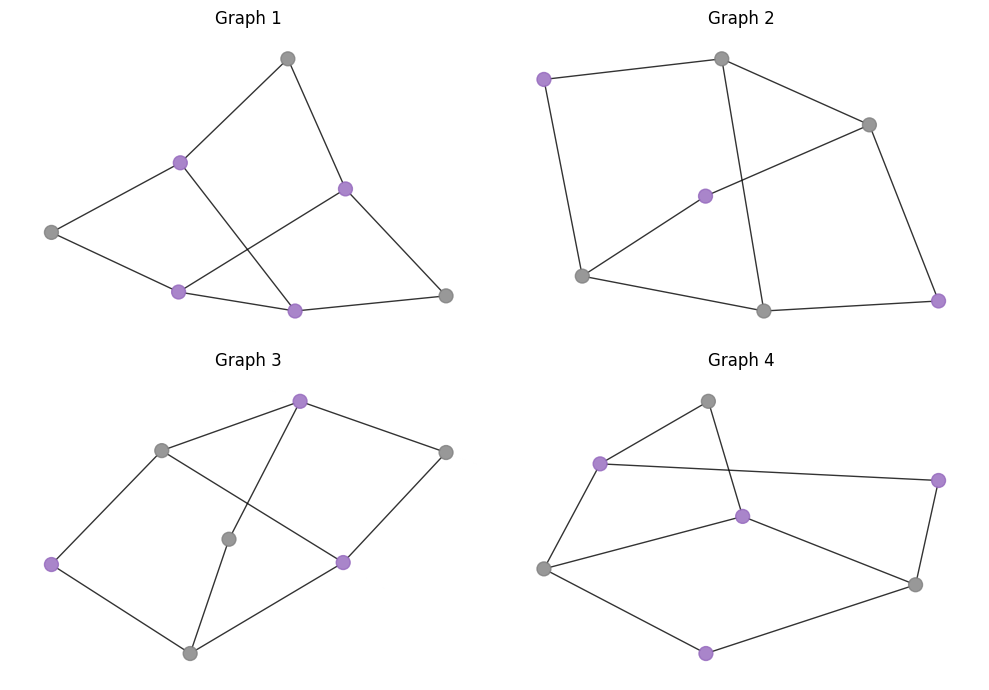

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # 2x2 lưới đồ thị

lists = [list1, list2, list3, list4]  # Danh sách các list đầu vào
for i, ax in enumerate(axes.flat):
    colors = ["tab:grey" if j == 0 else "tab:purple" for j in lists[i]]
    pos = rx.spring_layout(graph)  # Layout riêng cho mỗi đồ thị
    plt.sca(ax)  # Đặt trục hiện tại
    rx.visualization.mpl_draw(graph, node_color=colors, node_size=100, alpha=0.8, pos=pos)
    ax.set_title(f"Graph {i+1}")

plt.tight_layout()
plt.show()


### **Tinh số đường cắt**

In [21]:
# Tính toán số vết cắt dựa vào 2 Node nối với cạnh đó
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))

cut_value= evaluate_sample(list1, graph)
print('The value of the cut is:', cut_value)
cut_value= evaluate_sample(list2, graph)
print('The value of the cut is:', cut_value)
cut_value= evaluate_sample(list3, graph)
print('The value of the cut is:', cut_value)
cut_value= evaluate_sample(list4, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 6
The value of the cut is: 6
The value of the cut is: 8
The value of the cut is: 8
